# Assignment 1 - Text analytics
***

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import re
import math
import random
import unicodedata 
import string
import nltk

### Download if not imported
nltk.download('gutenberg')
nltk.download('punkt')

from collections import Counter
from nltk.util import ngrams
from nltk.corpus import gutenberg

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\sofia.baltzi\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sofia.baltzi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Let's Keep a dictionary of the most known contractions for future use.

In [2]:
contractions = {
"n't": "not",
"'t": "not",
"'ve": "have",
"'ll": "will",
"'s": "is",
"'d": "would",
"'m": "am",
"''em": "them"    
}

## Corpus: "The parent's assistant, by Maria Edgeworth"
***

In [3]:
### Download corpus as a large string.
corpus = gutenberg.raw(fileids='edgeworth-parents.txt')
corpus = corpus.lower()

## Remove Special Characters from Corpus
***

In [4]:
# Declare
def special_char_remove(corpus: str) -> str:
    """
        Inputs: Corpus
        Outputs: Corpus with no special characters
    """
    # Remove theese
    corpus = re.sub(r'[^a-zA-z.?!\']', ' ', corpus)
    
    # Fix for the title and further subtitles.
    corpus = corpus.replace('[', '')
    corpus = corpus.replace(']', '.')
    
    # Remove Punctuation 's
    corpus = corpus.replace('\'s', '')
    # Replace Carriage Return with nothing
    corpus = corpus.replace('\r', '')
    # Replace New-Line with space
    corpus = corpus.replace('\n', ' ')
    return corpus


# Run
corpus = special_char_remove(corpus)

## Convert to list of sentences
***

In [5]:
# Declare
def sentence_tokenization(text:str) -> list:
    """
        Inputs: Corpus Text
        Outputs: List of sentences
    """
    sentence_list = nltk.sent_tokenize(''.join(text))
    return sentence_list

# Run
sentence_list = sentence_tokenization(corpus)

## Convert to list of words
***

In [6]:
# Declare
def word_tokenization(text:str) -> list:
    """
        Inputs: A sentence.
        Outputs: A list of words that the sentence consists of.
    """
    words = nltk.word_tokenize(text)
    
    # Remove contractions
    words = [f  if f not in contractions.keys() else contractions[f] for f in words]
    return words

# Run it for every entry in the sentence_list
corpus_in_list_of_words = [word_tokenization(f) for f in sentence_list]

In [7]:
### Sanity Check (The length of the sentences and the list of word sentences must be the same)
assert len(sentence_list) == len(corpus_in_list_of_words)

## Splitting in Train-Development-Test Set
***

In [8]:
### Shuffle the corpus so the sentences/words are distrubuted fairly across the corpus.(Optional)
random.seed(30)
random.shuffle(corpus_in_list_of_words)

In [9]:
### And then break it into Train-Dev-Test Sets, according to the 60-20-20 Rule.
train_length = math.floor(0.6 * len(corpus_in_list_of_words))
dev_length   = test_length = math.floor(0.2 * len(corpus_in_list_of_words))

In [10]:
### Sanity Check (The sum of the lengths must be equal or lower than the original dataset)
assert train_length + dev_length + test_length <= len(corpus_in_list_of_words)

In [11]:
train_corpus = [f for f in corpus_in_list_of_words[0 : train_length]]
dev_corpus   = [f for f in corpus_in_list_of_words[train_length : train_length + dev_length]]
test_corpus  = [f for f in corpus_in_list_of_words[train_length + dev_length:]]

### Create Uni/Bi/Tri-Grams Counter Functions.
***

In [12]:
def calc_unigrams(corpus: list) -> Counter:
    """
        Inputs: A Corpus as a list of sentences.
        Outputs: The unigram count.
    """
    unigram_counter = Counter()
    for sentence in corpus:
        unigram_counter.update([gram for gram in ngrams(sentence, 1, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<e>')])
    return unigram_counter

def calc_bigrams(corpus: list) -> Counter:
    """
        Inputs: A Corpus as a list of sentences.
        Outputs: The bigram count.
    """
    bigram_counter = Counter()
    for sentence in corpus:
        bigram_counter.update([gram for gram in ngrams(sentence, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<e>')])
    return bigram_counter


def calc_trigrams(corpus: list) -> Counter:
    """
        Inputs: A Corpus as a list of sentences.
        Outputs: The trigram count.
    """
    trigram_counter = Counter()
    for sentence in corpus:
        trigram_counter.update([gram for gram in ngrams(sentence, 3, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<e>')])
    return trigram_counter

### Use Train Set to Create Vocabulary and OOV words
***

In [13]:
# Declare
def create_vocabulary_and_oov(corpus:list) -> (list, list):
    """
        Finds all words (unigrams) that appear under 5 times and 
        adds them to OOV list.
        Also updates corpus by replacing them with token "UNK".
        
        Inputs: A Corpus as a list of sentences.
        Outputs: A Corpus as a list of sentences with UNK , the vocabulary and the OOV list.
    """
    # Find under 10 occurance words.
    unigram_counter = calc_unigrams(corpus)
    OOV_words = {k[0]:"UNK" for k, v in unigram_counter.items() if v < 10}
    # Replace them
    new_corpus = []
    for sentence in corpus:
        new_corpus.append([OOV_words.get(n,n) for n in sentence])
        
    vocabulary = set([f[0] for f in unigram_counter.keys() if f[0] not in OOV_words])
    
    return new_corpus, vocabulary, OOV_words

# Run
train_corpus, vocabulary, OOV_words = create_vocabulary_and_oov(train_corpus)

### Use Vocabulary and OOV words to clean Development and Test Sets
***

In [14]:
# Declare
def clean_according_to_train(corpus:list, vocabulary: dict, OOV_words:list) -> list:
    """
        Cleans the corpus according to the vocabulary 
        and OOV_words list provided. Replaces words not
        in vocabulary or in OOV_words with UNK.
        Inputs: A corpus
        Outpus: The cleaned corpus.
    """
    clean_corpus = []
    for sentence in corpus:
        updated_sentence = ['UNK' if ((f not in vocabulary) or (f in OOV_words)) else f for f in sentence]
        clean_corpus.append(updated_sentence)
    return clean_corpus

# Run
dev_corpus = clean_according_to_train(dev_corpus, vocabulary, OOV_words)
test_corpus = clean_according_to_train(test_corpus, vocabulary, OOV_words)

## Question (i)
***

In [15]:
unigram_counter = calc_unigrams(train_corpus)
bigram_counter = calc_bigrams(train_corpus)
trigram_counter = calc_trigrams(train_corpus)
V_length = len(vocabulary)

### Top 5 per category
***

In [16]:
unigram_counter.most_common(5)

[(('UNK',), 13602),
 (('the',), 4691),
 (('.',), 4573),
 (('to',), 3089),
 (('and',), 2989)]

In [17]:
bigram_counter.most_common(5)

[(('.', '<e>'), 4559),
 (('the', 'UNK'), 1680),
 (('UNK', 'UNK'), 1616),
 (('UNK', '.'), 1358),
 (('UNK', 'and'), 953)]

In [18]:
trigram_counter.most_common(5)

[(('.', '<e>', '<e>'), 4559),
 (('UNK', '.', '<e>'), 1352),
 (('!', '<e>', '<e>'), 848),
 (('?', '<e>', '<e>'), 674),
 (('<s>', '<s>', 'i'), 472)]

##  Bi-gram Probability Calculation

### $ P(w_2|w_1) = \frac{C(w_1,w_2) + \alpha}{C(w_1) + \alpha \cdot|V|} $

* $ C(w_1,w_2) $ : bigram count
* $ C(w_1) $ : unigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter 
* |V|: vocabulary size

   

In [19]:
def calc_bi_prob(word1:str, word2:str, alpha:float, bigram_counter:Counter, unigram_counter:Counter, V_length:int) -> float:
    """
        Calculates the bi-gram probability of 2 consecutive words, based on the bigram_counter C(w1,w2)
        the unigram counter C(w1) as well as the hyperparameter a (Laplace add-a smoothing). We also need
        the length of the unigram words for the smoothing function.
    """
    #Bigram prob + laplace smoothing
    bigram_prob = (bigram_counter[(word1, word2)] + alpha) / (unigram_counter[(word1,)] + alpha*V_length)
    return bigram_prob

## Tri-gram Probability Calculation

### $ P(w_3|w_1,w_2) = \frac{C(w_1,w_2,w_3) + \alpha}{C(w_1,w_2) + \alpha \cdot |V|} $

* $ C(w_1,w_2,w_3) $ : trigram count
* $ C(w_1,w_2) $ : bigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter 
* |V|: vocabulary size

In [20]:
def calc_tri_prob(word1:str, word2:str, word3:str, alpha:float, trigram_counter:Counter, bigram_counter:Counter,  V_length:int) -> float:
    """
        Calculates the tri-gram probability of 3 consecutive words, based on the trigram_counter C(w1,w2,w3)
        the bigram_counter C(w1,w2) as well as the hyperparameter a (Laplace add-a smoothing). We also need
        the length of the bigram words for the smoothing function.
    """
    #Bigram prob + laplace smoothing
    trigram_prob = (trigram_counter[(word1,word2,word3)] +alpha) / (bigram_counter[(word1,word2)] + alpha*V_length)
    return trigram_prob

### Tune alpha using development set for bigram
***

In [21]:
perpl = []
HC_list = []
alpha_list = np.linspace(0.001,0.1,100)
for alpha in alpha_list:
    sum_prob = 0
    bigram_cnt = 0
    for sent in dev_corpus:
        sent = ['<s>']  + sent + ['<e>']
        for idx in range(1,len(sent)):
            bigram_prob = calc_bi_prob(word1=sent[idx-1], word2=sent[idx], alpha=alpha, bigram_counter=bigram_counter, unigram_counter=unigram_counter, V_length=V_length)
            sum_prob += math.log2(bigram_prob)
            bigram_cnt+=1

    HC_list.append(-sum_prob / bigram_cnt)
    perpl.append(math.pow(2,(-sum_prob / bigram_cnt)))
    

perpl = np.array(perpl)
entropy = np.array(HC_list)
best_alpha_bi = alpha_list[np.argmin(perpl)]

print(f"The lowest perplexity/entropy regarding bigram model is : {round(np.min(perpl),3)} / {round(np.min(entropy),3)} at alpha= {np.round(best_alpha_bi, 3)}")

The lowest perplexity/entropy regarding bigram model is : 52.032 / 5.701 at alpha= 0.015


### Plot Results
***

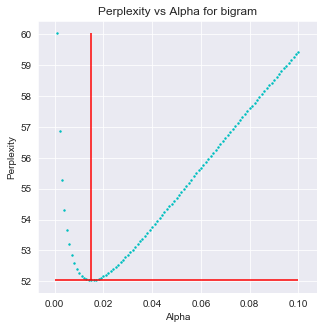

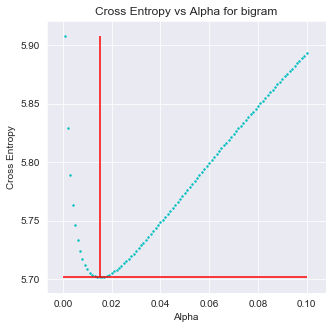

In [22]:
plt.figure(figsize=(5,5))
plt.scatter(alpha_list, perpl, c='c', s=2)
plt.hlines(y=perpl.min(), xmin=0, xmax=0.10, colors='r')
plt.vlines(x=round(alpha_list[perpl.argmin()], 4), ymin=min(perpl), ymax=max(perpl), colors='r')
plt.xlabel("Alpha")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Alpha for bigram")
plt.show()

#---------------------------#

plt.figure(figsize=(5,5))
plt.scatter(alpha_list, entropy, c='c', s=2)
plt.hlines(y=entropy.min(), xmin=0, xmax=0.10, colors='r')
plt.vlines(x=round(alpha_list[entropy.argmin()], 4), ymin=min(entropy), ymax=max(entropy), colors='r')
plt.xlabel("Alpha")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy vs Alpha for bigram")
plt.show()

### Tune alpha using development set for trigram
***

In [23]:
perpl = []
HC_list = []
alpha_list = np.linspace(0.001,0.1,100)
for alpha in alpha_list:
    sum_prob = 0
    trigram_cnt = 0
    for sent in dev_corpus:
        sent = ['<s>'] + ['<s>'] + sent + ['<e>'] + ['<e>']
        for idx in range(2,len(sent)):
            trigram_prob = calc_tri_prob(word1=sent[idx-2], word2=sent[idx-1], word3=sent[idx], alpha=alpha, trigram_counter=trigram_counter, bigram_counter=bigram_counter, V_length=V_length)
            sum_prob += math.log2(trigram_prob)
            trigram_cnt+=1

    HC_list.append(-sum_prob / trigram_cnt)
    perpl.append(math.pow(2,(-sum_prob / trigram_cnt)))
perpl = np.array(perpl)
entropy = np.array(HC_list)
best_alpha_tri = alpha_list[np.argmin(perpl)]

print(f"The lowest perplexity / entropy regarding trigram model is : {round(np.min(perpl),3)} / {round(np.min(entropy),3)} at alpha= {np.round(best_alpha_tri, 3)}")

The lowest perplexity / entropy regarding trigram model is : 96.218 / 6.588 at alpha= 0.008


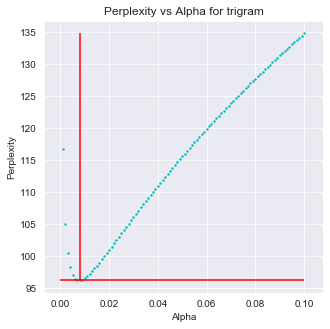

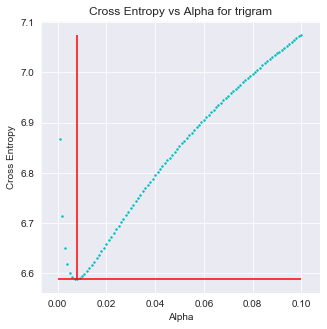

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(alpha_list, perpl, c='c', s=2)
plt.hlines(y=perpl.min(), xmin=0, xmax=0.10, colors='r')
plt.vlines(x=round(alpha_list[perpl.argmin()], 4), ymin=min(perpl), ymax=max(perpl), colors='r')
plt.xlabel("Alpha")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Alpha for trigram")
plt.show()

#-----------------------------------#

plt.figure(figsize=(5,5))
plt.scatter(alpha_list, entropy, c='c', s=2)
plt.hlines(y=entropy.min(), xmin=0, xmax=0.10, colors='r')
plt.vlines(x=round(alpha_list[entropy.argmin()], 4), ymin=min(entropy), ymax=max(entropy), colors='r')
plt.xlabel("Alpha")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy vs Alpha for trigram")
plt.show()

## Question (ii)
***
#### Here, we need to select correct sentences from the test set and calculate the log-prob of them based on our trained language models.
#### First, let's randomly select 10 sentences.


In [25]:
### For reproducability purposes
np.random.seed(666)

In [26]:
correct_sentences = [test_corpus[f] for f in np.random.randint(low=0, high=len(test_corpus), size=10)]

#### We also define a function that randomly selects words to create fake sentences of the same length as the correct ones

In [27]:
def create_fake_sentences(correct_sentences:list) -> list:
    fake_sentences = []
    for sentence in correct_sentences:
        rand_words = [list(vocabulary)[f] for f in np.random.randint(low=0, high=len(vocabulary), size=len(sentence))]
        fake_sentences.append(' '.join(rand_words))
    return fake_sentences

In [28]:
fake_sentences = create_fake_sentences(correct_sentences)

In [29]:
fake_corpus_list_of_words = [word_tokenization(f) for f in fake_sentences]
fake_corpus=clean_according_to_train(fake_corpus_list_of_words, vocabulary, OOV_words)

### Bigram model Calculations
***

In [30]:
sum_prob = 0
log_prob_bigram_correct=[]
for correct in correct_sentences:
    sent = ['<s>']  + correct + ['<e>']
    for idx in range(1,len(sent)):
        bigram_prob = calc_bi_prob(word1=sent[idx-1], word2=sent[idx], alpha=best_alpha_bi, bigram_counter=bigram_counter, unigram_counter=unigram_counter, V_length=V_length)
        sum_prob += math.log2(bigram_prob)
        bigram_cnt+=1  
    log_prob_bigram_correct.append(sum_prob)
    sum_prob = 0

In [31]:
sum_prob = 0
log_prob_bigram_fake=[]
for fake in fake_corpus:
    sent = ['<s>']  + fake + ['<e>']
    for idx in range(1,len(sent)):
        bigram_prob = calc_bi_prob(word1=sent[idx-1], word2=sent[idx], alpha=best_alpha_bi, bigram_counter=bigram_counter, unigram_counter=unigram_counter, V_length=V_length)
        sum_prob += math.log2(bigram_prob)
        bigram_cnt+=1
    log_prob_bigram_fake.append(sum_prob)
    sum_prob = 0

In [53]:
#Log probabilities of correct vs fake sentences in bigram model
pd.set_option('display.max_colwidth',1)
df1 = pd.DataFrame({"Correct Sentence":correct_sentences, "Log Probability Correct":log_prob_bigram_correct, "Fake Sentence":fake_corpus,  "Log Probability Fake":log_prob_bigram_fake})
##df1.to_excel("output.xlsx")
df1

,Correct Sentence,Log Probability Correct,Fake Sentence,Log Probability Fake
0,"[dr., middleton, UNK, me, and, now, he, will, UNK, of, his, confidence, in, me, .]",-75.584906,"[corner, understand, market, twelve, english, dress, men, downs, last, how, worked, told, gathered, running, fond]",-182.250820
1,"[repeated, he, UNK, the, light, to, his, face, .]",-51.145972,"[arthur, expected, sophy, where, halfpenny, has, reasonable, safe, opened]",-100.876712
2,"[grant, had, some, UNK, fine, raspberries, .]",-43.641907,"[early, saw, returned, landlady, bid, dark, charming]",-90.842118
3,"[and, louisa, also, desired, me, said, she, to, return, to, you, this, flora, .]",-104.340313,"[command, beg, mischief, think, nonsense, smiling, fixed, dark, master, arms, caught, throw, either, public]",-167.559026
4,"[you, may, go, back, and, tell, her, so, .]",-46.320648,"[safe, flora, been, ', friends, many, then, recollect, cry]",-113.196567
5,"[no, sir, nothing, answered, hal, in, a, UNK, tone, like, one, who, was, well, UNK, with, the, UNK, of, UNK, UNK, .]",-121.326119,"[had, mamma, over, health, boys, lad, brother, eager, other, fall, mount, fortune, warm, him, looking, passed, music, belonged, whatever, pulled, case, often]",-264.129754
6,"[this, poor, little, lamb, of, mine, was, what, kept, me, so, long, .]",-102.384218,"[enter, fall, sake, after, say, merchants, dear, age, laughed, lie, say, whispered, age]",-151.796720
7,"[yes, but, you, do, though, said, bell, more, UNK, .]",-53.239781,"[daughter, round, joy, quite, seeds, three, o, been, beautiful, have]",-132.162867
8,"[he, !]",-4.159435,"[this, person]",-24.787463
9,"[said, frederick, to, mr., eden, UNK, hold, of, his, hand, .]",-56.833448,"[off, employed, me, king, thanked, churchill, there, account, archers, dropped, dinner]",-132.537197


### Trigram model Calculations
***

In [33]:
sum_prob = 0
log_prob_trigram_correct=[]
for correct in correct_sentences:
    # This was wrong in trigram we need 2 starts not 1
    sent = ['<s>'] + ['<s>']  + correct + ['<e>'] + ['<e>']
    for idx in range(2,len(sent)):
        trigram_prob = calc_tri_prob(word1=sent[idx-2], word2=sent[idx-1], word3=sent[idx], alpha=best_alpha_tri, trigram_counter=trigram_counter, bigram_counter=bigram_counter, V_length=V_length)
        sum_prob += math.log2(trigram_prob)  
    log_prob_trigram_correct.append(sum_prob)
    sum_prob = 0

In [34]:
sum_prob = 0
log_prob_trigram_fake=[]
for fake in fake_corpus:
    # This was wrong in trigram we need 2 starts not 1
    sent = ['<s>']  + ['<s>']  + fake + ['<e>'] + ['<e>']
    for idx in range(2,len(sent)):
        trigram_prob = calc_tri_prob(word1=sent[idx-2], word2=sent[idx-1], word3=sent[idx], alpha=best_alpha_tri, trigram_counter=trigram_counter, bigram_counter=bigram_counter, V_length=V_length)
        sum_prob += math.log2(trigram_prob)  
    log_prob_trigram_fake.append(sum_prob)
    sum_prob = 0

In [56]:
#Log probabilities of correct vs fake sentences in trigram model
df2 = pd.DataFrame({"Correct Sentence":correct_sentences, "Log Probability Correct":log_prob_trigram_correct, "Fake Sentence":fake_corpus,  "Log Probability Fake":log_prob_trigram_fake})
##df2.to_excel("output.xlsx")
df2

,Correct Sentence,Log Probability Correct,Fake Sentence,Log Probability Fake
0,"[dr., middleton, UNK, me, and, now, he, will, UNK, of, his, confidence, in, me, .]",-108.529423,"[corner, understand, market, twelve, english, dress, men, downs, last, how, worked, told, gathered, running, fond]",-171.644158
1,"[repeated, he, UNK, the, light, to, his, face, .]",-65.263145,"[arthur, expected, sophy, where, halfpenny, has, reasonable, safe, opened]",-101.912912
2,"[grant, had, some, UNK, fine, raspberries, .]",-61.819836,"[early, saw, returned, landlady, bid, dark, charming]",-90.870436
3,"[and, louisa, also, desired, me, said, she, to, return, to, you, this, flora, .]",-119.281333,"[command, beg, mischief, think, nonsense, smiling, fixed, dark, master, arms, caught, throw, either, public]",-161.547442
4,"[you, may, go, back, and, tell, her, so, .]",-48.766623,"[safe, flora, been, ', friends, many, then, recollect, cry]",-104.242537
5,"[no, sir, nothing, answered, hal, in, a, UNK, tone, like, one, who, was, well, UNK, with, the, UNK, of, UNK, UNK, .]",-124.331029,"[had, mamma, over, health, boys, lad, brother, eager, other, fall, mount, fortune, warm, him, looking, passed, music, belonged, whatever, pulled, case, often]",-234.646295
6,"[this, poor, little, lamb, of, mine, was, what, kept, me, so, long, .]",-120.912154,"[enter, fall, sake, after, say, merchants, dear, age, laughed, lie, say, whispered, age]",-141.952931
7,"[yes, but, you, do, though, said, bell, more, UNK, .]",-64.306605,"[daughter, round, joy, quite, seeds, three, o, been, beautiful, have]",-121.160582
8,"[he, !]",-1.786683,"[this, person]",-30.460089
9,"[said, frederick, to, mr., eden, UNK, hold, of, his, hand, .]",-70.057251,"[off, employed, me, king, thanked, churchill, there, account, archers, dropped, dinner]",-123.127593


## Question (iii)
***

### Estimate language cross-entropy and perplexity of bigram model.
***

In [36]:
test_sequence = []
for sent in test_corpus:
    test_sequence += ['<s>']  + sent + ['<e>']

sum_prob = 0
bigram_cnt = 0
for idx in range(1,len(test_sequence)):
    if test_sequence[idx] != '<s>':
        bigram_prob = calc_bi_prob(word1=test_sequence[idx-1], word2=test_sequence[idx], alpha=best_alpha_bi, bigram_counter=bigram_counter, unigram_counter=unigram_counter, V_length=V_length)
        sum_prob += math.log2(bigram_prob)
        bigram_cnt+=1
        
HC = -sum_prob / bigram_cnt
perpl = math.pow(2,HC)

print("Language Cross Entropy: {0:.3f}".format(HC))
print("Language Perplexity: {0:.3f}".format(perpl))

Language Cross Entropy: 5.654
Language Perplexity: 50.364


### Estimate language cross-entropy and perplexity of trigram model.
***

In [37]:
test_sequence = []
for sent in test_corpus:
    test_sequence += ['<s>'] + ['<s>'] + sent + ['<e>'] + ['<e>']

sum_prob = 0
trigram_cnt = 0
for idx in range(2,len(test_sequence)):
    if test_sequence[idx] != '<s>':
        trigram_prob = calc_tri_prob(word1=test_sequence[idx-2], word2=test_sequence[idx-1], word3=test_sequence[idx], alpha=best_alpha_tri, trigram_counter=trigram_counter, bigram_counter=bigram_counter, V_length=V_length)
        sum_prob += math.log2(trigram_prob)
        trigram_cnt+=1
        
HC = -sum_prob / trigram_cnt
perpl = math.pow(2,HC)

print("Language Cross Entropy: {0:.3f}".format(HC))
print("Language Perplexity: {0:.3f}".format(perpl))

Language Cross Entropy: 6.548
Language Perplexity: 93.572


## Question (iv)
***

#### Linear interpolation for bigram and trigram model combination.

In [57]:
HC_list = []
perpl = []
lamda_list = np.linspace(0.001,1,100)

for lamda in lamda_list:
    sum_prob = 0
    ngram_cnt = 0
    for sent in dev_corpus:
        sent = ['<s>'] + ['<s>'] + sent + ['<e>'] + ['<e>']
        for idx in range(2,len(sent)):
            bigram_prob = calc_bi_prob(word1=sent[idx-1], word2=sent[idx], alpha=alpha, bigram_counter=bigram_counter, unigram_counter=unigram_counter, V_length=V_length)
            trigram_prob = calc_tri_prob(word1=sent[idx-2], word2=sent[idx-1], word3=sent[idx], alpha=alpha, trigram_counter=trigram_counter, bigram_counter=bigram_counter, V_length=V_length)
            sum_prob += (lamda * math.log2(trigram_prob)) +((1-lamda) * math.log2(bigram_prob))
            ngram_cnt+=1 

    HC_list.append(-sum_prob / ngram_cnt)
    perpl.append(math.pow(2,(-sum_prob / ngram_cnt)))

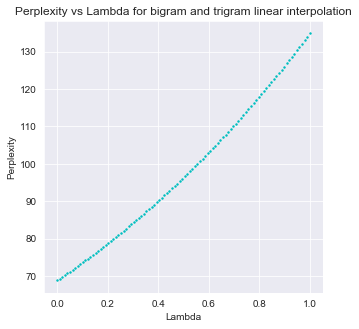

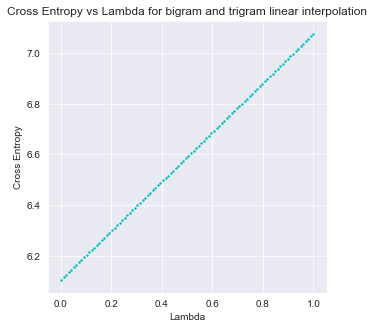

In [58]:
plt.figure(figsize=(5,5))
plt.scatter(lamda_list, perpl, c='c', s=2)
plt.xlabel("Lambda")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Lambda for bigram and trigram linear interpolation")
plt.show()

# ----------------- #

plt.figure(figsize=(5,5))
plt.scatter(lamda_list, HC_list, c='c', s=2)
plt.xlabel("Lambda")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy vs Lambda for bigram and trigram linear interpolation")
plt.show()